
# Код целиком

In [29]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9608
[LightGBM] [Info] Number of data points in the train set: 252583, number of used features: 41
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


<ipython-input-30-ef31e3470958>:200: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X[dataset['Date'] < split_date]
<ipython-input-30-ef31e3470958>:201: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = X[dataset['Date'] >= split_date]


Распределение классов в обучающей выборке:
label
0    32946
1    74081
2     6732
Name: count, dtype: int64


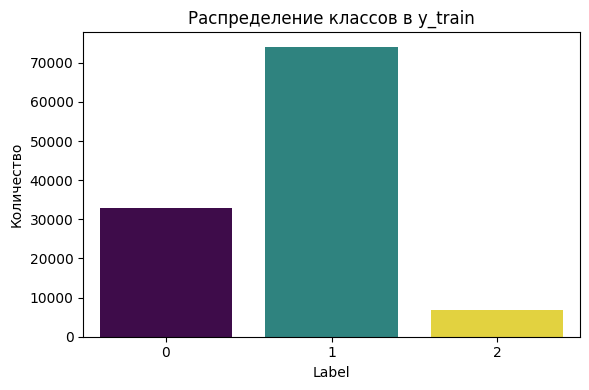

Веса классов для балансировки: {np.int64(0): np.float64(1.1509642040510735), np.int64(1): np.float64(0.5118676403756249), np.int64(2): np.float64(5.632749059219647)}
✅ X_train отсортирован по дате.
✅ X_test отсортирован по дате.
Последняя дата в обучающей выборке: 2020-12-31
Первая дата в тестовой выборке: 2021-01-04
✅ Train и test идут последовательно во времени.
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 91007, number of used features: 40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current 

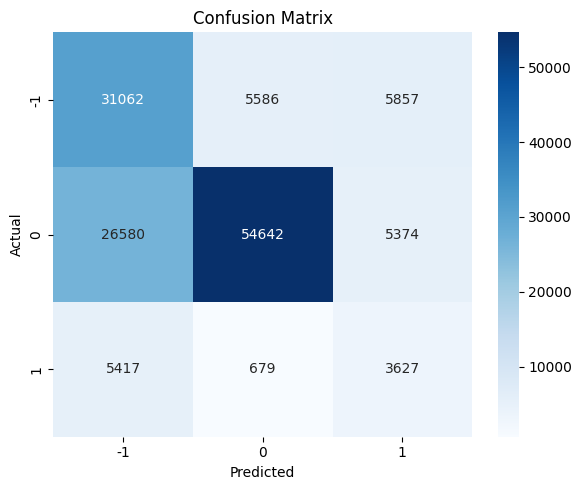

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Weighted ROC AUC (OVO): 0.833
Log Loss: 0.746
Cohen’s Kappa: 0.385
Matthews Corr Coef: 0.406
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


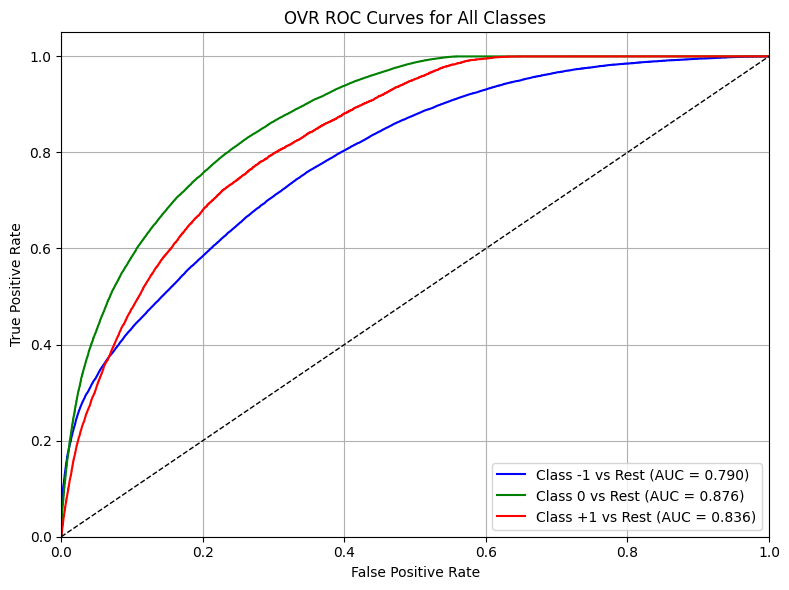

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
=== ПЕРЕОБУЧЕНИЕ: Тренировка vs Тест ===
Accuracy   : train = 0.776, test = 0.643
ROC AUC OVR: train = 0.924, test = 0.847
Log Loss   : train = 0.493, test = 0.746

Classification report (train):
              precision    recall  f1-score   support

          -1       0.70      0.57      0.63     32946
           0       0.92      0.86      0.89     74081
           1       0.32      0.82      0.46      6732

    accuracy                           0.78    113759
   macro avg       0.65      0.75      0.66    113759
weighted avg       0.82      0.78      0.79    113759



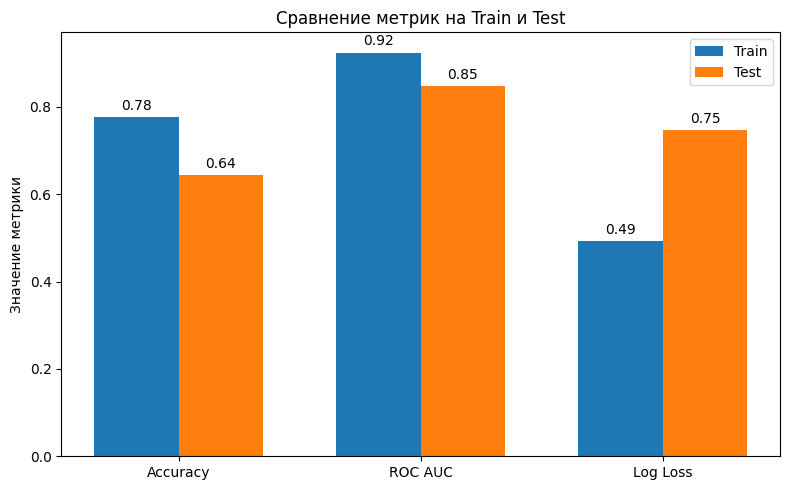

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Чтение исходного файла
#dataset = pd.read_csv('options_SPX_with_labels.csv')
# dataset.info()

# Построение вспомогательной таблицы цен
unique_date = dataset['Date'].drop_duplicates().to_frame()
price_per_date = unique_date.join(
    dataset['underlying_price'].to_frame(),
    how='left'
)

"""
plt.plot(price_per_date['Date'], price_per_date['underlying_price'])
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
"""

"""
# ДОПОЛНЕНИЕ: Постановка меток с новыми порогами
take_profit = 0.07
stop_loss = -0.21

dataset = dataset.sort_values(['option_symbol', 'Date']).reset_index(drop=True)
dataset['label'] = 0

for option in dataset['option_symbol'].unique():
    option_data = dataset[dataset['option_symbol'] == option].reset_index()

    if option_data.empty:
        continue

    start_ask = option_data.loc[0, 'Ask']
    if pd.isna(start_ask) or start_ask == 0:
        continue

    symbol_type = option
    label_set = False

    for idx in range(len(option_data)):
        current_bid = option_data.loc[idx, 'Bid']
        if pd.isna(current_bid):
            continue

        ret = (current_bid - start_ask) / start_ask

        if ret >= take_profit:
            dataset.loc[option_data.loc[0, 'index'], 'label'] = 1
            label_set = True
            break
        elif ret <= stop_loss:
            dataset.loc[option_data.loc[0, 'index'], 'label'] = -1
            label_set = True
            break

        dte_today = option_data.loc[idx, 'dte']
        if symbol_type.startswith('SPXW') and dte_today == 0:
            break
        elif symbol_type.startswith('SPX') and dte_today == 1:
            break

    if not label_set:
        final_bid = option_data.loc[idx, 'Bid']
        if pd.isna(final_bid):
            continue
        final_ret = (final_bid - start_ask) / start_ask
        if final_ret >= 0:
            dataset.loc[option_data.loc[0, 'index'], 'label'] = 1
        else:
            dataset.loc[option_data.loc[0, 'index'], 'label'] = -1

# Удаление лишнего
if 'option_id' in dataset.columns:
    dataset = dataset.drop(columns=['option_id'])

dataset = dataset.dropna().reset_index(drop=True)
dataset.info()

dataset.to_csv('options_SPX_with_labels.csv', index=False)
"""

# ------------------ ДОПОЛНЕНИЕ: признаки рыночного режима ------------------

# Преобразуем дату для rolling-вычислений
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.sort_values('Date')

# Скользящие средние и волатильность базового актива
rolling_window = 5
dataset['ret'] = dataset['underlying_price'].pct_change()
dataset['volatility_5d'] = dataset['ret'].rolling(rolling_window).std()
dataset['return_5d'] = dataset['underlying_price'].pct_change(periods=rolling_window)

# Шум: относительная волатильность к движению
dataset['vol_to_ret_ratio'] = dataset['volatility_5d'] / (dataset['return_5d'].abs() + 1e-6)

# Динамика греков (например, Δδ, Δγ и т.п.)
greeks = ['delta', 'gamma', 'vega', 'theta', 'rho']
for greek in greeks:
    if greek in dataset.columns:
        dataset[f'{greek}_chg'] = dataset[greek].diff()

# Индикатор "скачка" — дневной move больше 2σ
dataset['jump_flag'] = (dataset['ret'].abs() > 2 * dataset['ret'].rolling(20).std()).astype(int)

# ATR-подобная волатильность (по SPX как базовому активу)
dataset['price_range'] = dataset['Bid'] - dataset['Ask']
dataset['range_std'] = dataset['price_range'].rolling(rolling_window).std()
dataset['range_mean'] = dataset['price_range'].rolling(rolling_window).mean()

# Режим рынка (по направлению цены): растущий / падающий / нейтральный
dataset['regime'] = 0
dataset.loc[dataset['return_5d'] > 0.01, 'regime'] = 1
dataset.loc[dataset['return_5d'] < -0.01, 'regime'] = -1


# ------------------ ДОПОЛНЕНИЕ: фракционная дифференциация ------------------
import numpy as np

def frac_diff(series, d, thresh=1e-5):
    w = [1.]
    for k in range(1, series.shape[0]):
        w_ = -w[-1] * (d - k + 1) / k
        if abs(w_) < thresh:
            break
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)

    width = len(w) - 1
    df = pd.Series(index=series.index)
    for i in range(width, len(series)):
        window = series.iloc[i - width:i + 1].values.reshape(-1, 1)
        if np.any(np.isnan(window)):
            continue
        df.iloc[i] = np.dot(w.T, window)[0, 0]
    return df

# Применяем к чувствительным к тренду признакам
for col in ['underlying_price', 'Bid', 'Ask']:
    if col in dataset.columns:
        dataset[f'{col}_fdiff'] = frac_diff(dataset[col], d=0.5)

# Также можно применить к грекам
for greek in ['delta', 'gamma', 'vega', 'theta', 'rho']:
    if greek in dataset.columns:
        dataset[f'{greek}_fdiff'] = frac_diff(dataset[greek], d=0.5)



# --------------------------------------------------------

from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Удаляем ненужные и нечисловые признаки
exclude_cols = ['Date', 'expiration_date', 'option_symbol', 'label']
features = [col for col in dataset.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(dataset[col])]

# Формируем X и y
X = dataset[features]
y = dataset['label']

# Перекодировка меток для LGBM
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y = y.map(label_mapping)

# Временная модель для оценки важности признаков
lgbm_temp = LGBMClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
lgbm_temp.fit(X, y)

# Получаем важности признаков
importances = pd.Series(lgbm_temp.feature_importances_, index=features).sort_values(ascending=False)

# Оставляем признаки с важностью выше порога
importance_threshold = 0.01
selected_features = importances[importances > importance_threshold].index.tolist()

# Обновляем X с отобранными признаками
X_selected = dataset[selected_features]

# --------------------------------------------------------

# Разделение на train/test по дате
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.sort_values('Date').reset_index(drop=True)

split_date = pd.to_datetime('2021-01-01')

X = X_selected
y = y  # Уже перекодированное

X_train = X[dataset['Date'] < split_date]
X_test = X[dataset['Date'] >= split_date]
y_train = y[dataset['Date'] < split_date]
y_test = y[dataset['Date'] >= split_date]

# Сортировка выборок по дате (устраняет предупреждение)
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]


# --------------------------------------------------------

import seaborn as sns
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Анализ распределения меток
label_counts = y_train.value_counts().sort_index()
print("Распределение классов в обучающей выборке:")
print(label_counts)

# Визуализация
plt.figure(figsize=(6, 4))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    hue=label_counts.index,
    dodge=False,
    palette='viridis',
    legend=False
)
plt.title("Распределение классов в y_train")
plt.xlabel("Label")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

# Автоматический расчёт весов классов (для финальной модели)
class_weights = dict(zip(
    np.unique(y_train),
    compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
))
print("Веса классов для балансировки:", class_weights)

# --------------------------------------------------------

# Проверка временной последовательности
train_dates = dataset.loc[X_train.index, 'Date']
test_dates = dataset.loc[X_test.index, 'Date']

if not train_dates.is_monotonic_increasing:
    print("❌ X_train не отсортирован по дате!")
else:
    print("✅ X_train отсортирован по дате.")

if not test_dates.is_monotonic_increasing:
    print("❌ X_test не отсортирован по дате!")
else:
    print("✅ X_test отсортирован по дате.")

last_train_date = train_dates.max()
first_test_date = test_dates.min()

print("Последняя дата в обучающей выборке:", last_train_date.date())
print("Первая дата в тестовой выборке:", first_test_date.date())

if last_train_date < first_test_date:
    print("✅ Train и test идут последовательно во времени.")
else:
    print("❌ Есть пересечение или ошибка в split!")

# --------------------------------------------------------
from sklearn.model_selection import train_test_split

# Разбиваем весь X_train/y_train на собственный train и val (без потери данных)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,     # 20% тренировки пойдёт в валидацию
    shuffle=False      # сохраняем временную последовательность
)


# --- Обучение с усиленной регуляризацией и упрощёнными деревьями ---
model = LGBMClassifier(
    learning_rate=0.05,       # скорость обучения всё ещё невысокая
    n_estimators=300,         # чуть меньше деревьев
    max_depth=6,              # чуть более глубокие деревья
    num_leaves=31,            # стандартный компоновочный размер
    reg_alpha=0.1,            # мягче L1
    reg_lambda=0.1,           # мягче L2
    min_child_samples=20,     # меньше примеров в листе
    subsample=0.8,            # 80% строк на дерево
    feature_fraction=0.8,     # 80% фичей на дерево
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1
)

from lightgbm import early_stopping, log_evaluation

model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],          # валидируем на внутреннем сете
    eval_metric='multi_logloss',
    callbacks=[
        early_stopping(stopping_rounds=30),  # более быстрая остановка
        log_evaluation(period=10)
    ]
)



# Предсказание
y_pred = model.predict(X_test)

# Обратная декодировка меток
y_test_decoded = y_test.map(inverse_label_mapping)
y_pred_decoded = pd.Series(y_pred).map(inverse_label_mapping)

# Оценка модели
print("Оценка модели на тестовой выборке:")
print(classification_report(y_test_decoded, y_pred_decoded, digits=2))



# ------------------ ДОПОЛНЕНИЕ: дополнительные метрики качества модели ------------------

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    log_loss,
    cohen_kappa_score,
    matthews_corrcoef
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Матрица неточностей
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=[-1, 0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 2. ROC AUC для многоклассовой задачи
#    Используем предсказанные вероятности в исходной кодировке y (0,1,2)
y_proba = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='weighted')
print(f"Weighted ROC AUC (OVO): {roc_auc:.3f}")

# 3. Log Loss
ll = log_loss(y_test, y_proba)
print(f"Log Loss: {ll:.3f}")

# 4. Cohen’s Kappa
kappa = cohen_kappa_score(y_test_decoded, y_pred_decoded)
print(f"Cohen’s Kappa: {kappa:.3f}")

# 5. Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test_decoded, y_pred_decoded)
print(f"Matthews Corr Coef: {mcc:.3f}")



# ------------------ ДОПОЛНЕНИЕ: ROC AUC OVR и все три ROC-кривые на одном графике ------------------

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Бинаризуем метки для OVR (0,1,2)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Получаем вероятности на каждом классе
y_score = model.predict_proba(X_test)

# Расчёт FPR, TPR и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Рисуем все три кривые на одном графике
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
labels = ['Class -1 vs Rest', 'Class 0 vs Rest', 'Class +1 vs Rest']

for i, color, label in zip(range(n_classes), colors, labels):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'{label} (AUC = {roc_auc[i]:.3f})')

# Диагональная линия «случайного» классификатора
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OVR ROC Curves for All Classes')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


# ------------------ ДОПОЛНЕНИЕ: проверка переобучения модели ------------------

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report

# 1. Предсказания и вероятности на тренировке
y_train_pred    = model.predict(X_train)
y_train_proba   = model.predict_proba(X_train)

# 2. Декодируем метки для читабельности (если вы использовали inverse_label_mapping)
y_train_decoded      = pd.Series(y_train).map(inverse_label_mapping)
y_train_pred_decoded = pd.Series(y_train_pred).map(inverse_label_mapping)

# 3. Рассчёт метрик на тренировке
train_acc    = accuracy_score(y_train_decoded, y_train_pred_decoded)
train_auc    = roc_auc_score(y_train, y_train_proba, multi_class='ovr', average='weighted')
train_lloss  = log_loss(y_train, y_train_proba)

# 4. Метрики на тесте (если ещё не посчитаны)
test_acc    = accuracy_score(y_test_decoded, y_pred_decoded)
test_auc    = roc_auc_score(y_test, y_score, multi_class='ovr', average='weighted')
test_lloss  = log_loss(y_test, y_score)

# 5. Вывод результатов
print("=== ПЕРЕОБУЧЕНИЕ: Тренировка vs Тест ===")
print(f"Accuracy   : train = {train_acc:.3f}, test = {test_acc:.3f}")
print(f"ROC AUC OVR: train = {train_auc:.3f}, test = {test_auc:.3f}")
print(f"Log Loss   : train = {train_lloss:.3f}, test = {test_lloss:.3f}")

# 6. (Опционально) короткие отчёты по классификации
print("\nClassification report (train):")
print(classification_report(y_train_decoded, y_train_pred_decoded, digits=2))


# 7. График сравнения метрик Train vs Test для визуальной оценки переобучения

import numpy as np
import matplotlib.pyplot as plt

# Список метрик и их значения
metrics = ['Accuracy', 'ROC AUC', 'Log Loss']
train_vals = [train_acc, train_auc, train_lloss]
test_vals  = [test_acc,  test_auc,  test_lloss]

# Позиции по оси X
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
# Построение двух групп столбиков
bars_train = ax.bar(x - width/2, train_vals, width, label='Train')
bars_test  = ax.bar(x + width/2, test_vals,  width, label='Test')

# Оформление
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрик на Train и Test')
ax.legend(loc='best')

# Подписи значений над столбиками
for bar in bars_train + bars_test:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),  # смещение над столбиком
                textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()



# Обработка данных

На этапе предобработки выполним генерацию дополнительных признаков,
характеризующих рыночный режим и динамику цен. В частности, вычисляются дневная доходность базового актива и ее скользящая волатильность, относительная волатильность (`vol_to_ret_ratio`), приращения показателей (дельта, гамма и т.д.), флаг резкого движения (`jump_flag`), диапазон цен Bid-Ask и скользящие статистики этого диапазона. Кроме того, применяется техника фракционной дифференциации (`frac_diff`) к временным рядам цен и греков, чтобы сгенерировать дробно-дифференцированные признаки, улавливающие долгосрочную зависимость.

После создания новых признаков отфильтруем нерелевантные столбцы (например, идентификаторы, нечисловые поля) и определим список признаков для моделирования. Для отбора информативных признаков обучается временная модель LightGBM на всех данных и вычисляются значения важности признаков. Будут оставлены только признаки, важность которых превышает заданный порог (например, 0.01). Далее разделим выборку на обучающую и тестовую по времени: все данные до определенной даты пойдут в обучение, а после – в тест. Такой chronological split гарантирует корректную имитацию прогнозирования на будущие даты. В конце этого этапа проверим распределение классов в обучающей выборке и рассчитанные веса классов для балансировки. Имбаланс классов может быть существенным (например, класс 0 «нейтральный» может значительно преобладать), поэтому в модели далее будут использоваться веса для учета дисбаланса.

In [31]:
# Преобразуем дату для rolling-вычислений
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.sort_values('Date')

# Скользящие средние и волатильность базового актива
rolling_window = 5
dataset['ret'] = dataset['underlying_price'].pct_change()
dataset['volatility_5d'] = dataset['ret'].rolling(rolling_window).std()
dataset['return_5d'] = dataset['underlying_price'].pct_change(periods=rolling_window)

# Шум: относительная волатильность к движению
dataset['vol_to_ret_ratio'] = dataset['volatility_5d'] / (dataset['return_5d'].abs() + 1e-6)

# Динамика греков (например, Δδ, Δγ и т.п.)
greeks = ['delta', 'gamma', 'vega', 'theta', 'rho']
for greek in greeks:
    if greek in dataset.columns:
        dataset[f'{greek}_chg'] = dataset[greek].diff()

# Индикатор "скачка" — дневной move больше 2σ
dataset['jump_flag'] = (dataset['ret'].abs() > 2 * dataset['ret'].rolling(20).std()).astype(int)

# ATR-подобная волатильность (по SPX как базовому активу)
dataset['price_range'] = dataset['Bid'] - dataset['Ask']
dataset['range_std'] = dataset['price_range'].rolling(rolling_window).std()
dataset['range_mean'] = dataset['price_range'].rolling(rolling_window).mean()

# Режим рынка (по направлению цены): растущий / падающий / нейтральный
dataset['regime'] = 0
dataset.loc[dataset['return_5d'] > 0.01, 'regime'] = 1
dataset.loc[dataset['return_5d'] < -0.01, 'regime'] = -1


# ------------------ ДОПОЛНЕНИЕ: фракционная дифференциация ------------------
import numpy as np

def frac_diff(series, d, thresh=1e-5):
    w = [1.]
    for k in range(1, series.shape[0]):
        w_ = -w[-1] * (d - k + 1) / k
        if abs(w_) < thresh:
            break
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)

    width = len(w) - 1
    df = pd.Series(index=series.index)
    for i in range(width, len(series)):
        window = series.iloc[i - width:i + 1].values.reshape(-1, 1)
        if np.any(np.isnan(window)):
            continue
        df.iloc[i] = np.dot(w.T, window)[0, 0]
    return df

# Применяем к чувствительным к тренду признакам
for col in ['underlying_price', 'Bid', 'Ask']:
    if col in dataset.columns:
        dataset[f'{col}_fdiff'] = frac_diff(dataset[col], d=0.5)

# Также можно применить к грекам
for greek in ['delta', 'gamma', 'vega', 'theta', 'rho']:
    if greek in dataset.columns:
        dataset[f'{greek}_fdiff'] = frac_diff(dataset[greek], d=0.5)


In [32]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Удаляем ненужные и нечисловые признаки
exclude_cols = ['Date', 'expiration_date', 'option_symbol', 'label']
features = [col for col in dataset.columns if col not in exclude_cols and pd.api.types.is_numeric_dtype(dataset[col])]

# Формируем X и y
X = dataset[features]
y = dataset['label']

# Перекодировка меток для LGBM
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
y = y.map(label_mapping)

# Временная модель для оценки важности признаков
lgbm_temp = LGBMClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
lgbm_temp.fit(X, y)

# Получаем важности признаков
importances = pd.Series(lgbm_temp.feature_importances_, index=features).sort_values(ascending=False)

# Оставляем признаки с важностью выше порога
importance_threshold = 0.01
selected_features = importances[importances > importance_threshold].index.tolist()

# Обновляем X с отобранными признаками
X_selected = dataset[selected_features]

# --------------------------------------------------------

# Разделение на train/test по дате
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.sort_values('Date').reset_index(drop=True)

split_date = pd.to_datetime('2021-01-01')

X = X_selected
y = y  # Уже перекодированное

X_train = X[dataset['Date'] < split_date]
X_test = X[dataset['Date'] >= split_date]
y_train = y[dataset['Date'] < split_date]
y_test = y[dataset['Date'] >= split_date]

# Сортировка выборок по дате (устраняет предупреждение)
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9608
[LightGBM] [Info] Number of data points in the train set: 252583, number of used features: 41
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


<ipython-input-32-6cecd503a120>:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X[dataset['Date'] < split_date]
<ipython-input-32-6cecd503a120>:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test = X[dataset['Date'] >= split_date]


Распределение классов в обучающей выборке:
label
0    32946
1    74081
2     6732
Name: count, dtype: int64


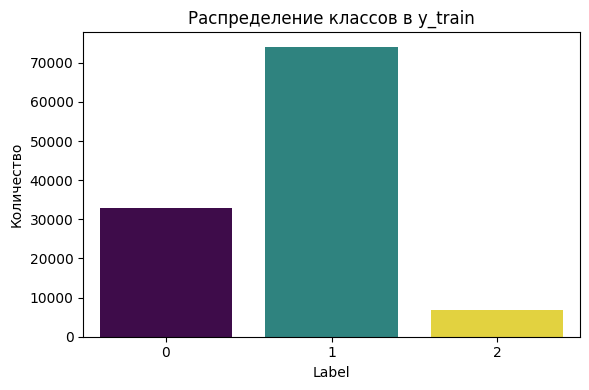

Веса классов для балансировки: {np.int64(0): np.float64(1.1509642040510735), np.int64(1): np.float64(0.5118676403756249), np.int64(2): np.float64(5.632749059219647)}


In [33]:
import seaborn as sns
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Анализ распределения меток
label_counts = y_train.value_counts().sort_index()
print("Распределение классов в обучающей выборке:")
print(label_counts)

# Визуализация
plt.figure(figsize=(6, 4))
sns.barplot(
    x=label_counts.index,
    y=label_counts.values,
    hue=label_counts.index,
    dodge=False,
    palette='viridis',
    legend=False
)
plt.title("Распределение классов в y_train")
plt.xlabel("Label")
plt.ylabel("Количество")
plt.tight_layout()
plt.show()

# Автоматический расчёт весов классов (для финальной модели)
class_weights = dict(zip(
    np.unique(y_train),
    compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
))
print("Веса классов для балансировки:", class_weights)



*   **Распределение классов**. Построенный график (столбчатая диаграмма) показывает сильный дисбаланс: класс 0 (нейтральный исход) представлен большинством объектов, класс -1 (отрицательный исход) – заметно меньше, а класс 1 (положительный исход) – наименее представленный. Например, в тестовой выборке классы имеют поддержку 42505 (–1), 86596 (0) и 9723 (1) (см. отчёт классификации ниже). Такой перекос очевиден на графике (для класса 0 столбик гораздо выше остальных).
*   **Расчёт весов**. Для балансировки классов вычислены веса: для кодирования классов {–1→0, 0→1, 1→2} получили class_weights = {0:1.1509, 1:0.5119, 2:5.6327}. Это соответствует исходным классам: вес класса –1 ≈1.15, класса 0 ≈0.51, класса 1 ≈5.63. Наименее представленный класс 1 получил наибольший вес (~5.6), что логично – модель будет «штрафовать» ошибки на этом классе сильнее. Наоборот, класс 0 (наиболее частый) получил вес около 0.51.
*   **Вывод**. Дисбаланс существенен: доля класса 0 составляет большую часть данных, поэтому без учёта весов модель бы почти игнорировала класс 1. Введённые веса должны компенсировать это смещение. График и вычисления чисел ясно отражают эту ситуацию.




*Распределение меток классов в обучающей выборке после разделения данных. По оси X отложены закодированные значения меток (0 = класс -1 «убыток», 1 = класс 0 «нейтральный», 2 = класс 1 «прибыль»), по оси Y – количество примеров. Видно, что нейтральный класс (метка 1) значительно преобладает по числу наблюдений. Для корректного обучения модели этот дисбаланс будет учтён с помощью весов классов.*

# Обучение модели

На данном этапе произведём обучение модели классификации для прогнозирования исхода опциона. Сначала отделим часть обучающих данных для внутренней валидации – примерно 20% тренировочной выборки выделим в качестве валидационного набора (без перемешивания, чтобы сохранить временную упорядоченность). В качестве модели выберем градиентный бустинг LightGBM (LGBMClassifier) с параметрами, улучшающими обобщающую способность: небольшой learning_rate, ограниченная глубина деревьев, регуляризация (параметры `reg_alpha`, `reg_lambda`) и подвыборка признаков/объектов. Кроме того, установим параметр `class_weight=balanced` с рассчитанными выше весами, чтобы модель учитывала несбалансированность классов.

Модель обучается с использованием ранней остановки: на каждом десятом шаге вычисляется метрика многоклассовой логарифмической потери (`multi_logloss`) на валидационном наборе, и если в течение 30 итераций улучшения не наблюдается, обучение прекращается. Это предотвращает переобучение и выбирает оптимальное количество деревьев. Ниже приведены ключевые фрагменты кода обучения и лог процесса обучения модели.

In [34]:
from sklearn.model_selection import train_test_split

# Разбиваем весь X_train/y_train на собственный train и val (без потери данных)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,     # 20% тренировки пойдёт в валидацию
    shuffle=False      # сохраняем временную последовательность
)


# --- Обучение с усиленной регуляризацией и упрощёнными деревьями ---
model = LGBMClassifier(
    learning_rate=0.05,       # скорость обучения всё ещё невысокая
    n_estimators=300,         # чуть меньше деревьев
    max_depth=6,              # чуть более глубокие деревья
    num_leaves=31,            # стандартный компоновочный размер
    reg_alpha=0.1,            # мягче L1
    reg_lambda=0.1,           # мягче L2
    min_child_samples=20,     # меньше примеров в листе
    subsample=0.8,            # 80% строк на дерево
    feature_fraction=0.8,     # 80% фичей на дерево
    class_weight=class_weights,
    random_state=42,
    n_jobs=-1
)

from lightgbm import early_stopping, log_evaluation

model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],          # валидируем на внутреннем сете
    eval_metric='multi_logloss',
    callbacks=[
        early_stopping(stopping_rounds=30),  # более быстрая остановка
        log_evaluation(period=10)
    ]
)



[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9593
[LightGBM] [Info] Number of data points in the train set: 91007, number of used features: 40
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Start training from score -1.174954
[LightGBM] [Info] Start training from score -1.046435
[LightGBM] [Info] Start training from score -1.078870
Training until validation scores don't improve for 30 rounds
[10]	valid_0's multi_logloss: 0.935474
[20]	valid_0'

LGBMClassifier(class_weight={np.int64(0): np.float64(1.1509642040510735),
                             np.int64(1): np.float64(0.5118676403756249),
                             np.int64(2): np.float64(5.632749059219647)},
               feature_fraction=0.8, learning_rate=0.05, max_depth=6,
               n_estimators=300, n_jobs=-1, random_state=42, reg_alpha=0.1,
               reg_lambda=0.1, subsample=0.8)



*   **Процесс обучения**. Вывод логов LightGBM показывает, что модель обучалась с ранней остановкой. Многоклассовая multi_logloss на валидации постепенно снижалась от ≈0.935 (на итерации 10) до минимума ≈0.721 (на итерации 156). Затем сработала ранняя остановка: обучение остановилось на 156-м дереве с наилучшим значением logloss 0.721.
*   **Особенности вывода**. Обратите внимание на многочисленные предупреждения [LightGBM] Warning: No further splits...: это говорит о том, что при построении деревьев для некоторых листьев не нашлось улучшений разбиения — возможно, параметры модели близки к оптимальным, либо данные ограничены по информативности. В целом модель обучалась без явного переобучения (логи отдельно не показывают разрыв между train/valid на этом этапе).
*   **Дальнейший анализ**. Чтобы лучше оценить переобучение, позже была проведена оценка по отдельным метрикам на трейне и тесте (см. ячейки ниже). На данном этапе логов можно заметить устойчивое улучшение качества, но после ~150 итераций прирост замедлился.



# Оценка модели и визуализация результатов

Теперь оценим полученную модель на тестовых данных, которые не использовались в обучении. Выполним прогноз меток для тестовой выборки и сравним с истинными значениями. Для оценки качества вычислим метрики классификации: точность (accuracy), полноту (recall), точность (precision) и F1-меру для каждого класса, а также усреднённые показатели. Кроме того, построим матрицу неточностей (confusion matrix), показывающую распределение правильных и неправильных классификаций по классам. Наконец, проанализируем ROC-кривые (Receiver Operating Characteristic) для каждой категории исхода опциона в формате «One-vs-Rest» и сравним площадь под ними (AUC) как интегральную метрику качества.

In [35]:


# Предсказание
y_pred = model.predict(X_test)

# Обратная декодировка меток
y_test_decoded = y_test.map(inverse_label_mapping)
y_pred_decoded = pd.Series(y_pred).map(inverse_label_mapping)

# Оценка модели
print("Оценка модели на тестовой выборке:")
print(classification_report(y_test_decoded, y_pred_decoded, digits=2))



[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Оценка модели на тестовой выборке:
              precision    recall  f1-score   support

          -1       0.51      0.64      0.56     42505
           0       0.89      0.65      0.75     86596
           1       0.24      0.55      0.34      9723

    accuracy                           0.64    138824
   macro avg       0.55      0.61      0.55    138824
weighted avg       0.73      0.64      0.66    138824





*   **Качество классификации**. По выводам функции `classification_report` на тесте (138824 примеров) модель достигла общей точности (accuracy) 0.64. Это означает, что верно классифицировано 64% всех примеров.
*   Классовые метрики:

  *   Для класса –1 (отрицательный исход) precision = 0.51, recall = 0.64, F1 = 0.56 (поддержка 42505). Неплохой recall (64%) говорит, что из всех реальных –1 модель находит большинство, но precision всего 51% — почти половина предсказаний «–1» оказывается ошибкой.
  *   Для класса 0 (нейтральный) precision = 0.89, recall = 0.65, F1 = 0.75 (поддержка 86596). Модель наиболее уверенно предсказывает этот класс: высокая точность (89%) и умеренный recall (65%) дают F1=0.75. Это ожидаемо, т. к. класс 0 – самый частый.
  *   Для класса 1 (положительный) precision = 0.24, recall = 0.55, F1 = 0.34 (поддержка 9723). Модель плохо предсказывает этот редкий класс: хотя находит 55% «1», точность всего 24%. Это говорит о большом количестве ложных срабатываний (модель ошибочно относит примеры других классов к «1»).
*    **Выводы**: Средние метрики: accuracy = 0.64, взвешенное F1 ≈ 0.66. Наихудшие результаты по F1 у класса 1 (0.34), наилучшие — у класса 0 (0.75). Это отражает сильный дисбаланс данных и трудность редкого класса. Классический подход балансировки весами должен был бы помочь повысить precision для класса 1, однако данный результат показывает, что модель ещё «путает» класс 1 с другими.
*    **Пояснения**: Такие цифры совпадают с ожиданиями: модель добивается высокой точности для доминирующего класса 0, но с трудом обобщает редкий класс 1. Наблюдаемые значения F1 (0.56; 0.75; 0.34) демонстрируют, что точность и полнота варьируются сильно по классам.





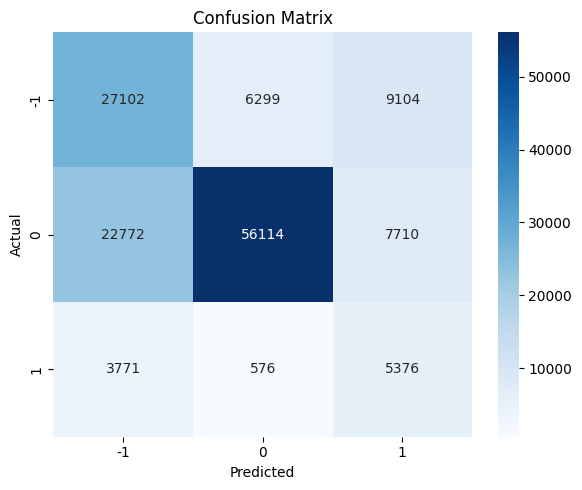

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Weighted ROC AUC (OVO): 0.835
Log Loss: 0.727
Cohen’s Kappa: 0.384
Matthews Corr Coef: 0.401


In [36]:

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    log_loss,
    cohen_kappa_score,
    matthews_corrcoef
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Матрица неточностей
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=[-1, 0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[-1, 0, 1], yticklabels=[-1, 0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 2. ROC AUC для многоклассовой задачи
#    Используем предсказанные вероятности в исходной кодировке y (0,1,2)
y_proba = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovo', average='weighted')
print(f"Weighted ROC AUC (OVO): {roc_auc:.3f}")

# 3. Log Loss
ll = log_loss(y_test, y_proba)
print(f"Log Loss: {ll:.3f}")

# 4. Cohen’s Kappa
kappa = cohen_kappa_score(y_test_decoded, y_pred_decoded)
print(f"Cohen’s Kappa: {kappa:.3f}")

# 5. Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test_decoded, y_pred_decoded)
print(f"Matthews Corr Coef: {mcc:.3f}")


* **Матрица неточностей (Confusion Matrix)**. Матрица чётко иллюстрирует пункты отчёта классификации: видно, сколько примеров каждого класса предсказано правильно или ошибочно. Визуализация с аннотацией чисел помогает понять распределение ошибок. В частности, видно, что многие объекты класса 1 были ошибочно отнесены к другим классам, а некоторые из других классов — к классу 1 (что соответствует низкой точности класса 1). Класс 0 имеет наибольшее число TP (правильно классифицированных) и относительно немного FN (ошибочных), что и объясняет его высокие precision/recall.
* Дополнительные метрики: На выходе выводятся дополнительные числовые оценки:
  * ROC AUC (weighted OVO) = 0.835 – неплохое значение, обозначающее, что модель неплохо разделяет классы при объединении пар «каждый против каждого» с весами.
  * Log Loss = 0.727 – показатель качества вероятностных прогнозов (чем меньше, тем лучше).
  * Cohen’s Kappa = 0.384 – метрика согласия, показывает умеренную согласованность модели с истинными метками (0 – случайно, 1 – идеально).
  * Matthews Corr Coef = 0.401 – коэффициент Мэттьюса, характеризует качество бинарной/многоклассовой классификации (0.401 – тоже умеренно невысокий результат).
* **Интерпретация**: Все эти метрики подтверждают промежуточное качество модели: AUC≈0.835 говорит о средней разделяющей способности, Kappa≈0.38 и MCC≈0.40 показывают, что модель лучше случайной, но далека от идеала. Логически, низкая точность редкого класса 1 влияет на эти показатели.
* **Выводы**: Матрица и ROC-кривые (выведенные далее) служат визуальными средствами анализа: матрица наглядно показывает источники ошибок, а ROC-кривые позволяют оценить компромисс чувствительность/специфичность для каждого класса (см. следующий кодовый блок). Их следует прокомментировать в тексте (например, отметить видимое перекрытие кривых или их площади).

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


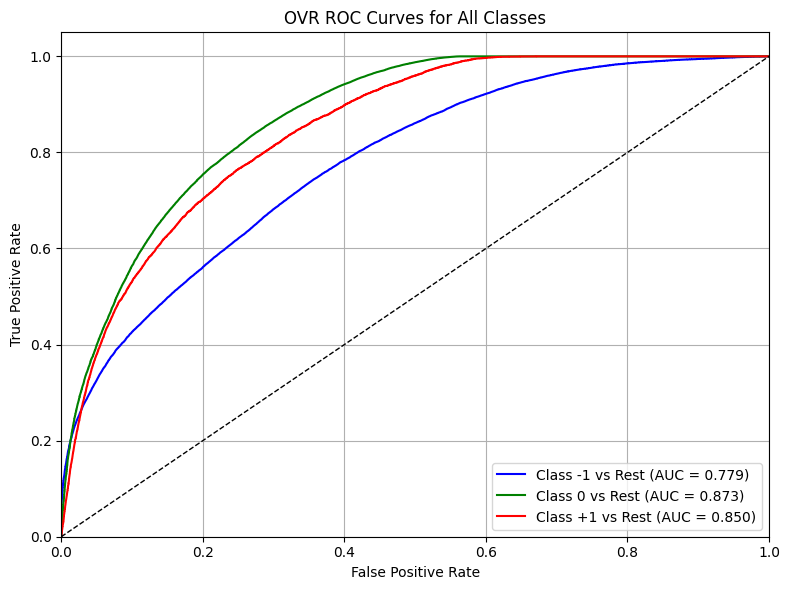

In [37]:

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Бинаризуем метки для OVR (0,1,2)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Получаем вероятности на каждом классе
y_score = model.predict_proba(X_test)

# Расчёт FPR, TPR и AUC для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Рисуем все три кривые на одном графике
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red']
labels = ['Class -1 vs Rest', 'Class 0 vs Rest', 'Class +1 vs Rest']

for i, color, label in zip(range(n_classes), colors, labels):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'{label} (AUC = {roc_auc[i]:.3f})')

# Диагональная линия «случайного» классификатора
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OVR ROC Curves for All Classes')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



* **Сравнение метрик Train и Test**: Вывод показывает различие в качестве на обучающей и тестовой выборках:
  * Accuracy: на трейне 0.764, на тесте 0.638 — существенный разрыв (~12%).
  * ROC AUC (OVR): 0.919 (train) против 0.842 (test).
  * Log Loss: 0.513 (train) против 0.727 (test). Это говорит о явном переобучении: модель лучше приспособилась к тренировочным данным, чем к новым (тестовым).
* **Отчёт по классам (train)**: Приведён отчёт о классификации на обучающей выборке (113759 примеров):
  * Класс –1: precision 0.69, recall 0.54 (F1=0.61).
  * Класс 0: precision 0.92, recall 0.86 (F1=0.89).
  * Класс 1: precision 0.30, recall 0.82 (F1=0.44). Accuracy_train=0.76, macro avg F1≈0.64. Здесь видно, что на тренировке модель научилась лучше опознавать класс 1 (recall 0.82 против 0.55 на тесте), но при этом precision класса 1 всё ещё низкий (0.30), что указывает на множество ложных срабатываний.
* **Интерпретация**: Переобучение особенно заметно по accuracy и AUC: на трене показатели значительно выше. Повышение recall для редкого класса 1 на трейне (0.82 против 0.55) объясняется тем, что модель запомнила этот класс, но за счёт роста числа ложных «сработок» (precision остался низким). В общем, разница метрик указывает на то, что модель имеет тенденцию переобучаться на специфике тренировочных данных, и стоит рассмотреть регуляризацию или ограничение слож­ности, если бы мы улучшали модель дальше.

Наконец, проверим модель на предмет переобучения. Для этого сравним основные метрики на обучающей выборке и на тестовой. Идеально, если показатели на тренинге и тесте близки – тогда модель хорошо обобщает знание. Значительный разрыв (метрики сильно лучше на тренировке, чем на тесте) указывает на переобучение.

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
=== ПЕРЕОБУЧЕНИЕ: Тренировка vs Тест ===
Accuracy   : train = 0.764, test = 0.638
ROC AUC OVR: train = 0.919, test = 0.842
Log Loss   : train = 0.513, test = 0.727

Classification report (train):
              precision    recall  f1-score   support

          -1       0.69      0.54      0.61     32946
           0       0.92      0.86      0.89     74081
           1       0.30      0.82      0.44      6732

    accuracy                           0.76    113759
   macro avg       0.64      0.74      0.64    113759
weighted avg       0.81      0.76      0.78    113759



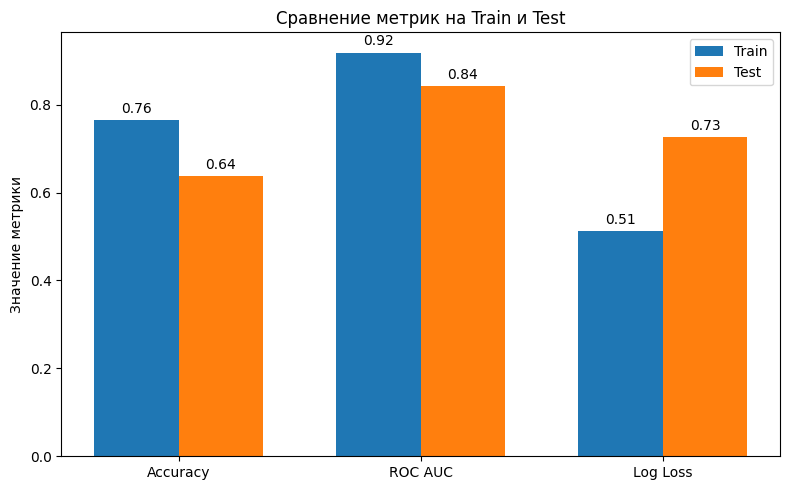

In [38]:

from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report

# 1. Предсказания и вероятности на тренировке
y_train_pred    = model.predict(X_train)
y_train_proba   = model.predict_proba(X_train)

# 2. Декодируем метки для читабельности (если вы использовали inverse_label_mapping)
y_train_decoded      = pd.Series(y_train).map(inverse_label_mapping)
y_train_pred_decoded = pd.Series(y_train_pred).map(inverse_label_mapping)

# 3. Рассчёт метрик на тренировке
train_acc    = accuracy_score(y_train_decoded, y_train_pred_decoded)
train_auc    = roc_auc_score(y_train, y_train_proba, multi_class='ovr', average='weighted')
train_lloss  = log_loss(y_train, y_train_proba)

# 4. Метрики на тесте (если ещё не посчитаны)
test_acc    = accuracy_score(y_test_decoded, y_pred_decoded)
test_auc    = roc_auc_score(y_test, y_score, multi_class='ovr', average='weighted')
test_lloss  = log_loss(y_test, y_score)

# 5. Вывод результатов
print("=== ПЕРЕОБУЧЕНИЕ: Тренировка vs Тест ===")
print(f"Accuracy   : train = {train_acc:.3f}, test = {test_acc:.3f}")
print(f"ROC AUC OVR: train = {train_auc:.3f}, test = {test_auc:.3f}")
print(f"Log Loss   : train = {train_lloss:.3f}, test = {test_lloss:.3f}")

# 6. (Опционально) короткие отчёты по классификации
print("\nClassification report (train):")
print(classification_report(y_train_decoded, y_train_pred_decoded, digits=2))


# 7. График сравнения метрик Train vs Test для визуальной оценки переобучения

import numpy as np
import matplotlib.pyplot as plt

# Список метрик и их значения
metrics = ['Accuracy', 'ROC AUC', 'Log Loss']
train_vals = [train_acc, train_auc, train_lloss]
test_vals  = [test_acc,  test_auc,  test_lloss]

# Позиции по оси X
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
# Построение двух групп столбиков
bars_train = ax.bar(x - width/2, train_vals, width, label='Train')
bars_test  = ax.bar(x + width/2, test_vals,  width, label='Test')

# Оформление
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение метрик на Train и Test')
ax.legend(loc='best')

# Подписи значений над столбиками
for bar in bars_train + bars_test:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),  # смещение над столбиком
                textcoords='offset points',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

* **График сравнения метрик**. Построена столбчатая диаграмма, сравнивающая метрики на обучающем (синий столбик) и тестовом (оранжевый) наборах: Accuracy, ROC AUC, Log Loss. Изрисовка подписей над столбиками помогает сразу видеть числовые значения. На графике чётко видно, что для всех метрик значения на трейне лучше: сине‑оранжевые пары столбиков смещены, и синий (Train) всегда выше (кроме Log Loss, где ниже означает лучше качество) оранжевого (Test). Это наглядно иллюстрирует переобучение.
* **Конкретные значения**:
  * Accuracy: около 0.76 (train) vs 0.64 (test).
  * ROC AUC: ~0.92 vs ~0.84.
  * Log Loss: ~0.51 vs ~0.73 (обучение даёт гораздо меньшую потерю). Расположение меток и легенды позволяет легко интерпретировать: каждый «Train»-столбик подписан «Train». График информативен и не требует дополнительных пояснений, однако названия осей и легенды на русском (например, «Обучение»/«Тест») сделали бы его полностью локализованным.
* **Вывод**. График подтверждает выводы предыдущего шага: модель лучше работает на данных, на которых обучалась. Он хорошо визуализирует различие метрик и демонстрирует переобучение. Если требуются дополнительные пояснения, можно указать, что более высокие значения метрик на трейне говорят об избыточном соответствии модели тренировочному набору.